In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import test_s_curve, hhRNADataset, hhATACDataset, test_paul, symsim_batches, cardiacRNADataset, cardiacATACDataset

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def traj_loss(recon_x, x, z, diff_sim, lamb_recon = 1, lamb_dist = 1):
    loss_recon = lamb_recon * F.mse_loss(recon_x, x)
    
    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    
    latent_sim = pairwise_distance(z)
#     print(np.isnan(latent_sim.detach().numpy()))
    
#     assert False
#     diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')
    
    # normalize latent similarity matrix
    latent_sim = latent_sim / torch.norm(latent_sim, p='fro')
    diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')

    # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
    loss_dist = - lamb_dist * torch.sum(diff_sim * latent_sim) 
    

    loss = loss_recon + loss_dist
    return loss, loss_recon, loss_dist

In [3]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 64,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    
    DPT1 = torch.FloatTensor(DPT1).to(device)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT2 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    
    DPT2 = torch.FloatTensor(DPT2).to(device)

In [10]:
def train_unpaired(model_rna, model_atac, disc, data_loader_rna, data_loader_atac, diff_sim_rna, diff_sim_atac, n_epochs = 50, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1):

    optimizer_rna = torch.optim.Adam(model_rna.parameters(), lr = learning_rate)
    optimizer_atac = torch.optim.Adam(model_atac.parameters(), lr = learning_rate)
    optimizer_D = torch.optim.Adam(disc.parameters(), lr = learning_rate)

    for epoch in range(n_epochs):
        iteration = max(len(data_loader_rna), len(data_loader_atac))
        for data in zip(data_loader_rna, data_loader_atac):
            # Update RNA Encoder
            data_rna, data_atac = data
            batch_cols_rna = data_rna['index'].to(device)
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count'].to(device)

            batch_expr_r_rna = model_rna(batch_expr_rna)
            z_rna = model_rna[:1](batch_expr_rna)

            train_loss_rna, loss_recon_rna, loss_dist_rna = traj_loss(batch_expr_r_rna, batch_expr_rna, z_rna, batch_sim_rna, lamb_r, lamb_d)

            train_loss_rna.backward()
            optimizer_rna.step()
            optimizer_rna.zero_grad()

            # Update ATAC Encoder
            batch_cols_atac = data_atac['index'].to(device)
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count'].to(device)

            batch_expr_r_atac = model_atac(batch_expr_atac)
            z_atac = model_atac[:1](batch_expr_atac)

            train_loss_atac, loss_recon_atac, loss_dist_atac = traj_loss(batch_expr_r_atac, batch_expr_atac, z_atac, batch_sim_atac, lamb_r, lamb_d)

            train_loss_atac.backward()
            optimizer_atac.step()
            optimizer_atac.zero_grad()

            # need to go through all the calculation again since the encoder has been updated, ERROR shows up in pytorch 1.5 and above.
            # see: https://github.com/pytorch/pytorch/issues/39141 
            z_rna = model_rna[:1](batch_expr_rna)
            z_atac = model_atac[:1](batch_expr_atac)

            # Update Discriminator
            D_loss_avg = 0
            n_iter = 20
            n_rna = batch_cols_rna.shape[0]
            n_atac = batch_cols_atac.shape[0]
            # note that detach here is necessary, use directly will cause error in encoder update later
            input_disc = torch.cat((z_rna.detach(), z_atac.detach()), dim = 0)
            target = torch.cat((torch.full((n_rna, ), 0, dtype = torch.float), torch.full((n_atac, ), 1, dtype = torch.float))).to(device)
            

            for i in range(n_iter):
                output = disc(input_disc)
                D_loss = F.binary_cross_entropy(output, target)
                D_loss_avg += D_loss.item()
                D_loss.backward()
                optimizer_D.step()
                optimizer_D.zero_grad()
            D_loss_avg /= n_iter

            # Update Encoder
            E_loss = -1 * F.binary_cross_entropy(disc(torch.cat((z_rna, z_atac), dim = 0)), target)
            E_loss.backward()
            optimizer_rna.step()
            optimizer_atac.step()
            optimizer_rna.zero_grad()
            optimizer_atac.zero_grad()

        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item())
            log_D = "Discriminator loss: {:.5f}".format(D_loss_avg)
            print("epoch: ", epoch, log_rna, log_atac, log_D)


In [11]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

In [12]:
train_unpaired(ae1, ae2, ae.discriminator().to(device), train_r1b1_loader, train_r1b2_loader, DPT1, DPT2, n_epochs=121, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1)

epoch:  0 RNA loss: 0.28367, RNA recon loss: 1.19822, RNA dist loss: -0.91455 ATAC loss: 0.22590, ATAC recon loss: 1.10441, ATAC dist loss: -0.87851 Discriminator loss: 0.55500
epoch:  10 RNA loss: -0.42694, RNA recon loss: 0.54954, RNA dist loss: -0.97649 ATAC loss: -0.45196, ATAC recon loss: 0.50183, ATAC dist loss: -0.95380 Discriminator loss: 0.61034
epoch:  20 RNA loss: -0.45896, RNA recon loss: 0.52374, RNA dist loss: -0.98270 ATAC loss: -0.42919, ATAC recon loss: 0.52769, ATAC dist loss: -0.95688 Discriminator loss: 0.63124
epoch:  30 RNA loss: -0.42717, RNA recon loss: 0.56030, RNA dist loss: -0.98747 ATAC loss: -0.51112, ATAC recon loss: 0.47407, ATAC dist loss: -0.98519 Discriminator loss: 0.58478
epoch:  40 RNA loss: -0.46377, RNA recon loss: 0.51611, RNA dist loss: -0.97988 ATAC loss: -0.50635, ATAC recon loss: 0.47686, ATAC dist loss: -0.98321 Discriminator loss: 0.61603
epoch:  50 RNA loss: -0.46891, RNA recon loss: 0.51779, RNA dist loss: -0.98670 ATAC loss: -0.52143, AT

## Merged Branch

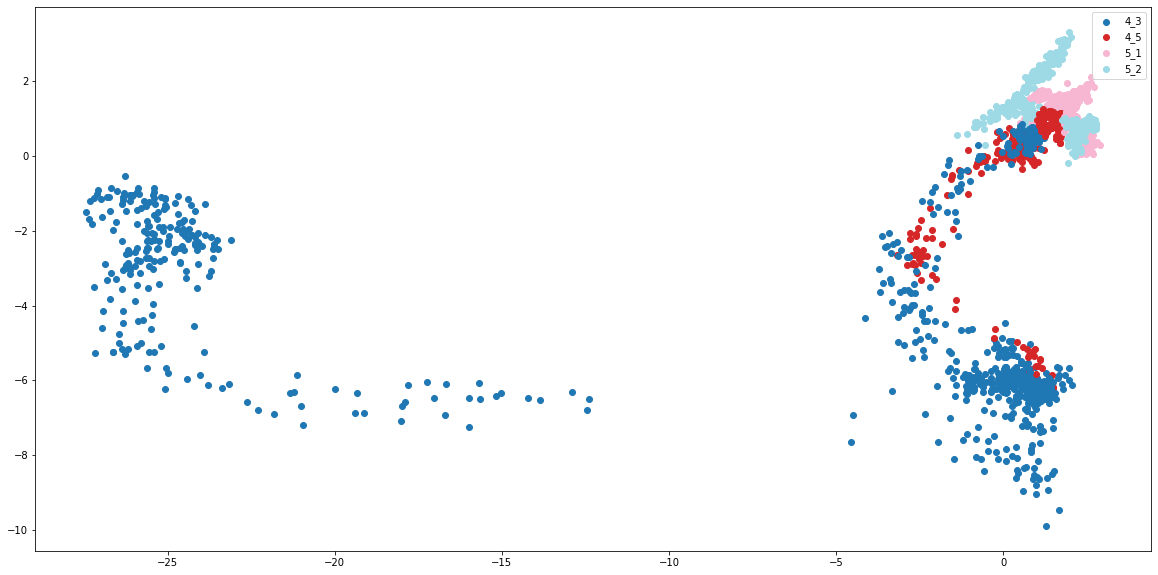

In [16]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)


for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)
fig.savefig("./result/Symsim/backbones.pdf")

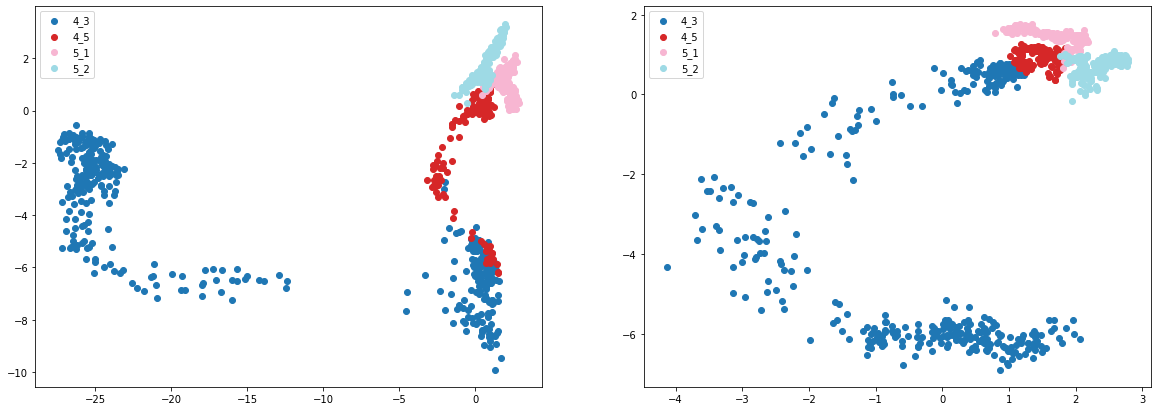

In [17]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1,2)

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[0].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)
axs[0].legend(cluster_types)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[1].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

axs[1].legend(cluster_types)

fig.savefig("./result/Symsim/backbones_separate.pdf")

## Merged Batch

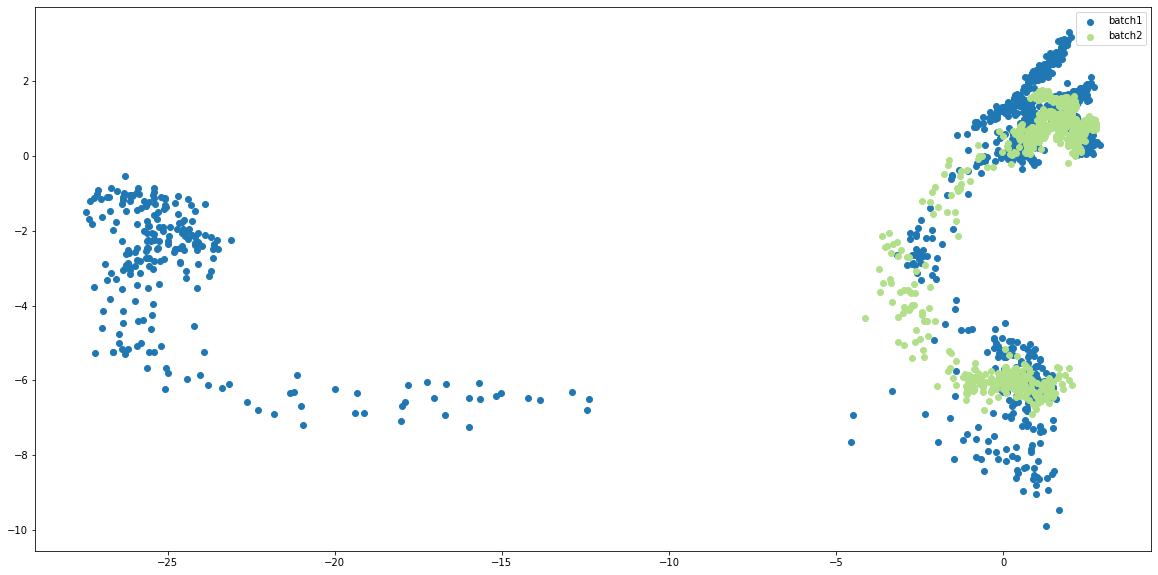

In [18]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
colormap = plt.cm.get_cmap("Paired")

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(1), label = "batch1", alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(2), label = "batch2", alpha = 1)

ax.legend()

fig.savefig("./result/Symsim/batches.pdf")

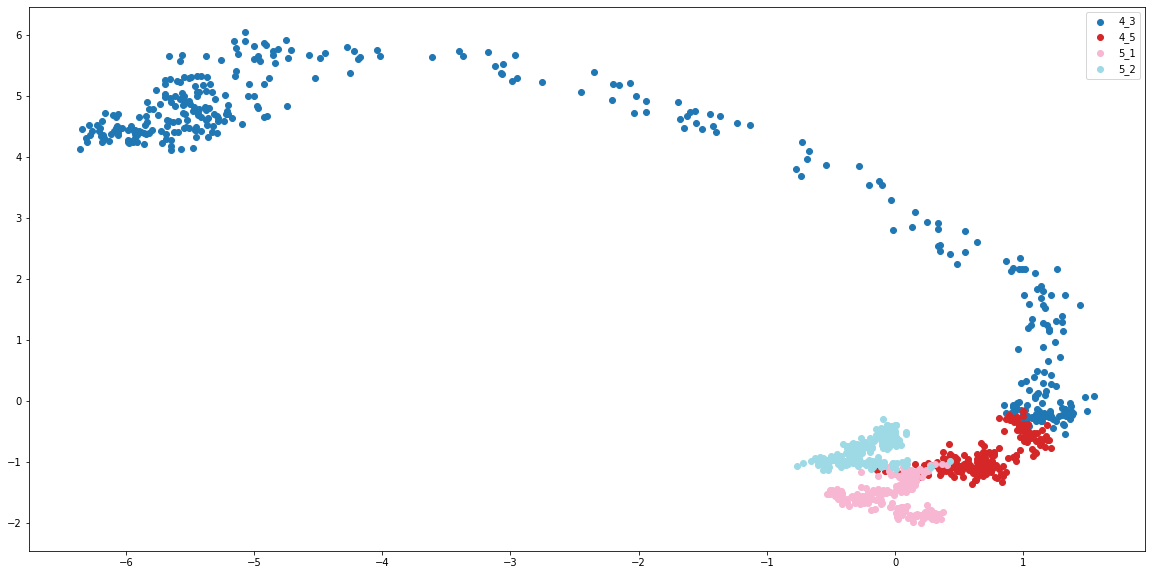

In [28]:
ae1.eval()
for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()


# data 3, oeHBC data, small one 
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

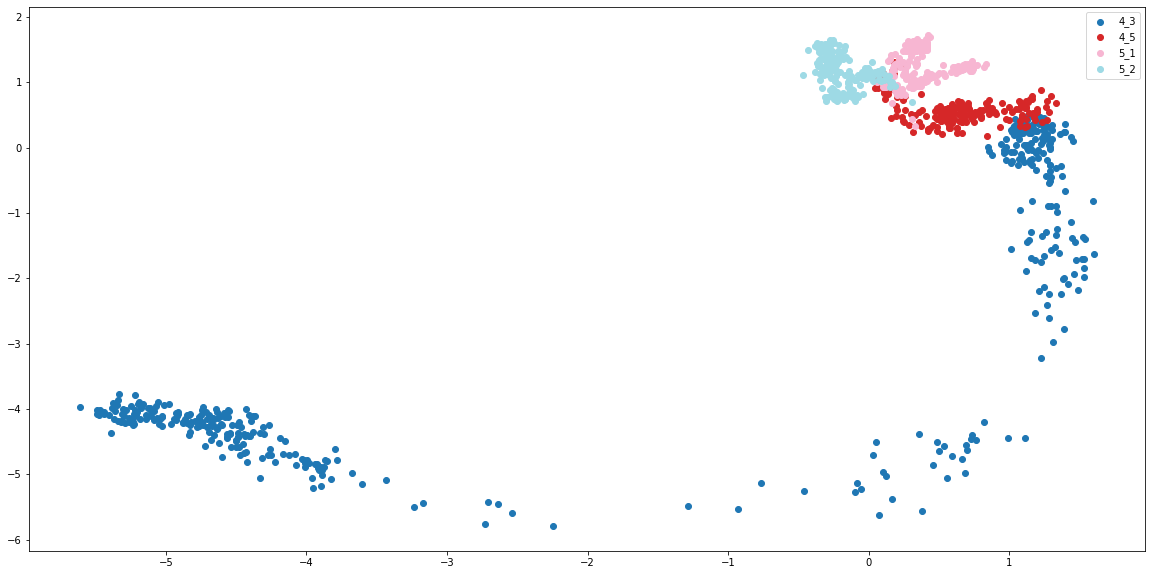

In [29]:
ae2.eval()
for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()


# data 3, oeHBC data, small one 
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)